In [20]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import tifffile as tf
import plotly.graph_objects as go
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})

In [21]:
# Load the dictionary from file
loaded_params = np.load("params.npz")

# Convert to regular Python dict (optional)
params = {k: loaded_params[k].item() if loaded_params[k].shape == () else loaded_params[k] for k in loaded_params}

# Set variables from dictionary explicitly
wl_TPA = params["wl_TPA"]
wl_ill = params["wl_ill"]
wl_det = params["wl_det"]
wl_p = params["wl_p"]
wl_S = params["wl_S"]
num_ap = params["num_ap"]
ref_index = params["ref_index"]
M = params["M"]
pinhole_radius_airy = params["pinhole_radius_airy"]
pinhole_radius = params["pinhole_radius"]
ap_durch_f = params["ap_durch_f"]
r_min = params["r_min"]
r_max = params["r_max"]
r_num = params["r_num"]
z_min = params["z_min"]
z_max = params["z_max"]
z_num = params["z_num"]
print(params)
r_array=np.linspace(r_min,r_max,r_num)
z_array=np.linspace(z_min,z_max,z_num)
theta_num=360
theta_array = np.linspace(0,360,theta_num)

{'wl_TPA': 0.9, 'wl_ill': 0.561, 'wl_det': 0.6, 'wl_p': 0.88, 'wl_S': 1.031, 'num_ap': 0.85, 'ref_index': 1.33, 'M': 32, 'pinhole_radius_airy': 1, 'pinhole_radius': 0.43058823529411766, 'ap_durch_f': 0.8309407549436357, 'r_min': -5, 'r_max': 5, 'r_num': 1001, 'z_min': -7, 'z_max': 7, 'z_num': 1201}


In [22]:
PSF_conventional = np.loadtxt(f'psf_conventional.csv', delimiter=',')
PSF_confocal = np.loadtxt(f'psf_confocal.csv', delimiter=',')
PSF_confocal_ideal= np.loadtxt(f'psf_confocal_ideal.csv', delimiter=',')
PSF_2p_conventional = np.loadtxt(f'psf_2p_conventional.csv', delimiter=',')
PSF_2p_confocal = np.loadtxt(f'psf_2p_confocal.csv', delimiter=',')
PSF_srs = np.loadtxt(f'psf_srs.csv', delimiter=',')

In [23]:
def plot_psf(psf, title, z_array, r_array, theta_array):
    cmap_norm=mpl.colors.LogNorm(1e-3,1)
    contour_levels=np.geomspace(1e-3,1,num=11)
    contourf_levels=np.geomspace(1e-3,1,num=31)
    cmap=mpl.cm.viridis

    fig, axs =plt.subplot_mosaic([['0','1'],['2','3']],per_subplot_kw={('1'):{'projection':'polar'},},layout='constrained',figsize=(19,14))
    fig.suptitle(title, fontsize=30)
    ax=axs['0']
    ax.set_title(r'Log PSF [a.u.]')
    ax.contourf(z_array, r_array, psf , levels=contourf_levels, cmap=cmap, norm=cmap_norm, extend='min')
    ax.contourf(z_array, -r_array, psf , levels=contourf_levels, cmap=cmap, norm=cmap_norm, extend='min')
    c1=ax.contour(z_array, r_array, psf, levels=contour_levels, colors='k', linestyles='-')
    c2=ax.contour(z_array, -r_array, psf, levels=contour_levels, colors='k', linestyles='-')
    ax.set_xlabel(r'z [\textmu m]')
    ax.set_ylabel(r'r [\textmu m]')
    ax.set_xlim([-4,4])
    ax.set_ylim([-2,2])
    cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=cmap_norm, cmap=cmap),ax=ax, orientation='vertical', )

    ax=axs['1']
    ax.set_title(r'$z=0$ plane')
    ax.contourf(theta_array, r_array, np.tile(psf[:,int(z_num/2)],(theta_num,1)).T, levels=np.linspace(0,1,num=31),cmap=cmap,norm=mpl.colors.Normalize(0,1),extend='min')
    cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0,1), cmap=cmap),ax=ax, orientation='vertical', )
    ax.set_ylim([0,1])

    ax=axs['2']
    boxcontent = '\n'.join((
        r'$\mathrm{NA}=%.2f$' % (num_ap, ),
        r'$n=%.2f$' % (ref_index, ),
        r'$\lambda_{\mathrm{p}}=%.0f\,\mathrm{nm}$' % (wl_p*10**3, ),
        r'$\lambda_{\mathrm{S}}=%.0f\,\mathrm{nm}$' % (wl_S*10**3, )))
    boxprops=dict(boxstyle='round', facecolor='wheat', alpha=0.7)
    ax.text(0.7, 0.7, boxcontent, transform=ax.transAxes, fontsize=18,
            verticalalignment='bottom', bbox=boxprops)

    ax.plot(z_array, psf[int(r_num/2),:],color='tab:blue')

    ax.set_xlabel(r'z [\textmu m]')
    ax.set_ylabel(r'Point Spread Function [a.u.]')
    ax.set_title(r'Axial extent ($r=0$)')
    ax.set_xlim(-2.5,2.5)
    ax.set_ylim(0.0,1.1)
    ax.grid(visible=True)
    

    ax=axs['3']
    boxcontent = '\n'.join((
        r'$\mathrm{NA}=%.2f$' % (num_ap, ),
        r'$n=%.2f$' % (ref_index, ),
        r'$\lambda_{\mathrm{p}}=%.0f\,\mathrm{nm}$' % (wl_p*10**3, ),
        r'$\lambda_{\mathrm{S}}=%.0f\,\mathrm{nm}$' % (wl_S*10**3, )))
    boxprops=dict(boxstyle='round', facecolor='wheat', alpha=0.7)
    ax.text(0.7, 0.7, boxcontent, transform=ax.transAxes, fontsize=18,
            verticalalignment='bottom', bbox=boxprops)

    ax.plot(r_array, psf[:,int(z_num/2)],color='tab:blue')

    ax.set_xlabel(r'r [\textmu m]')
    ax.set_ylabel(r'Point Spread Function [a.u.]')
    ax.set_title(r'Lateral extent ($z=0$)')
    ax.set_xlim(-0.8,0.8)
    ax.set_ylim(0.0,1.1)
    ax.grid(visible=True)
    fig.show()


C:\Users\dan20\AppData\Local\Temp\ipykernel_10928\2069810545.py:65: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


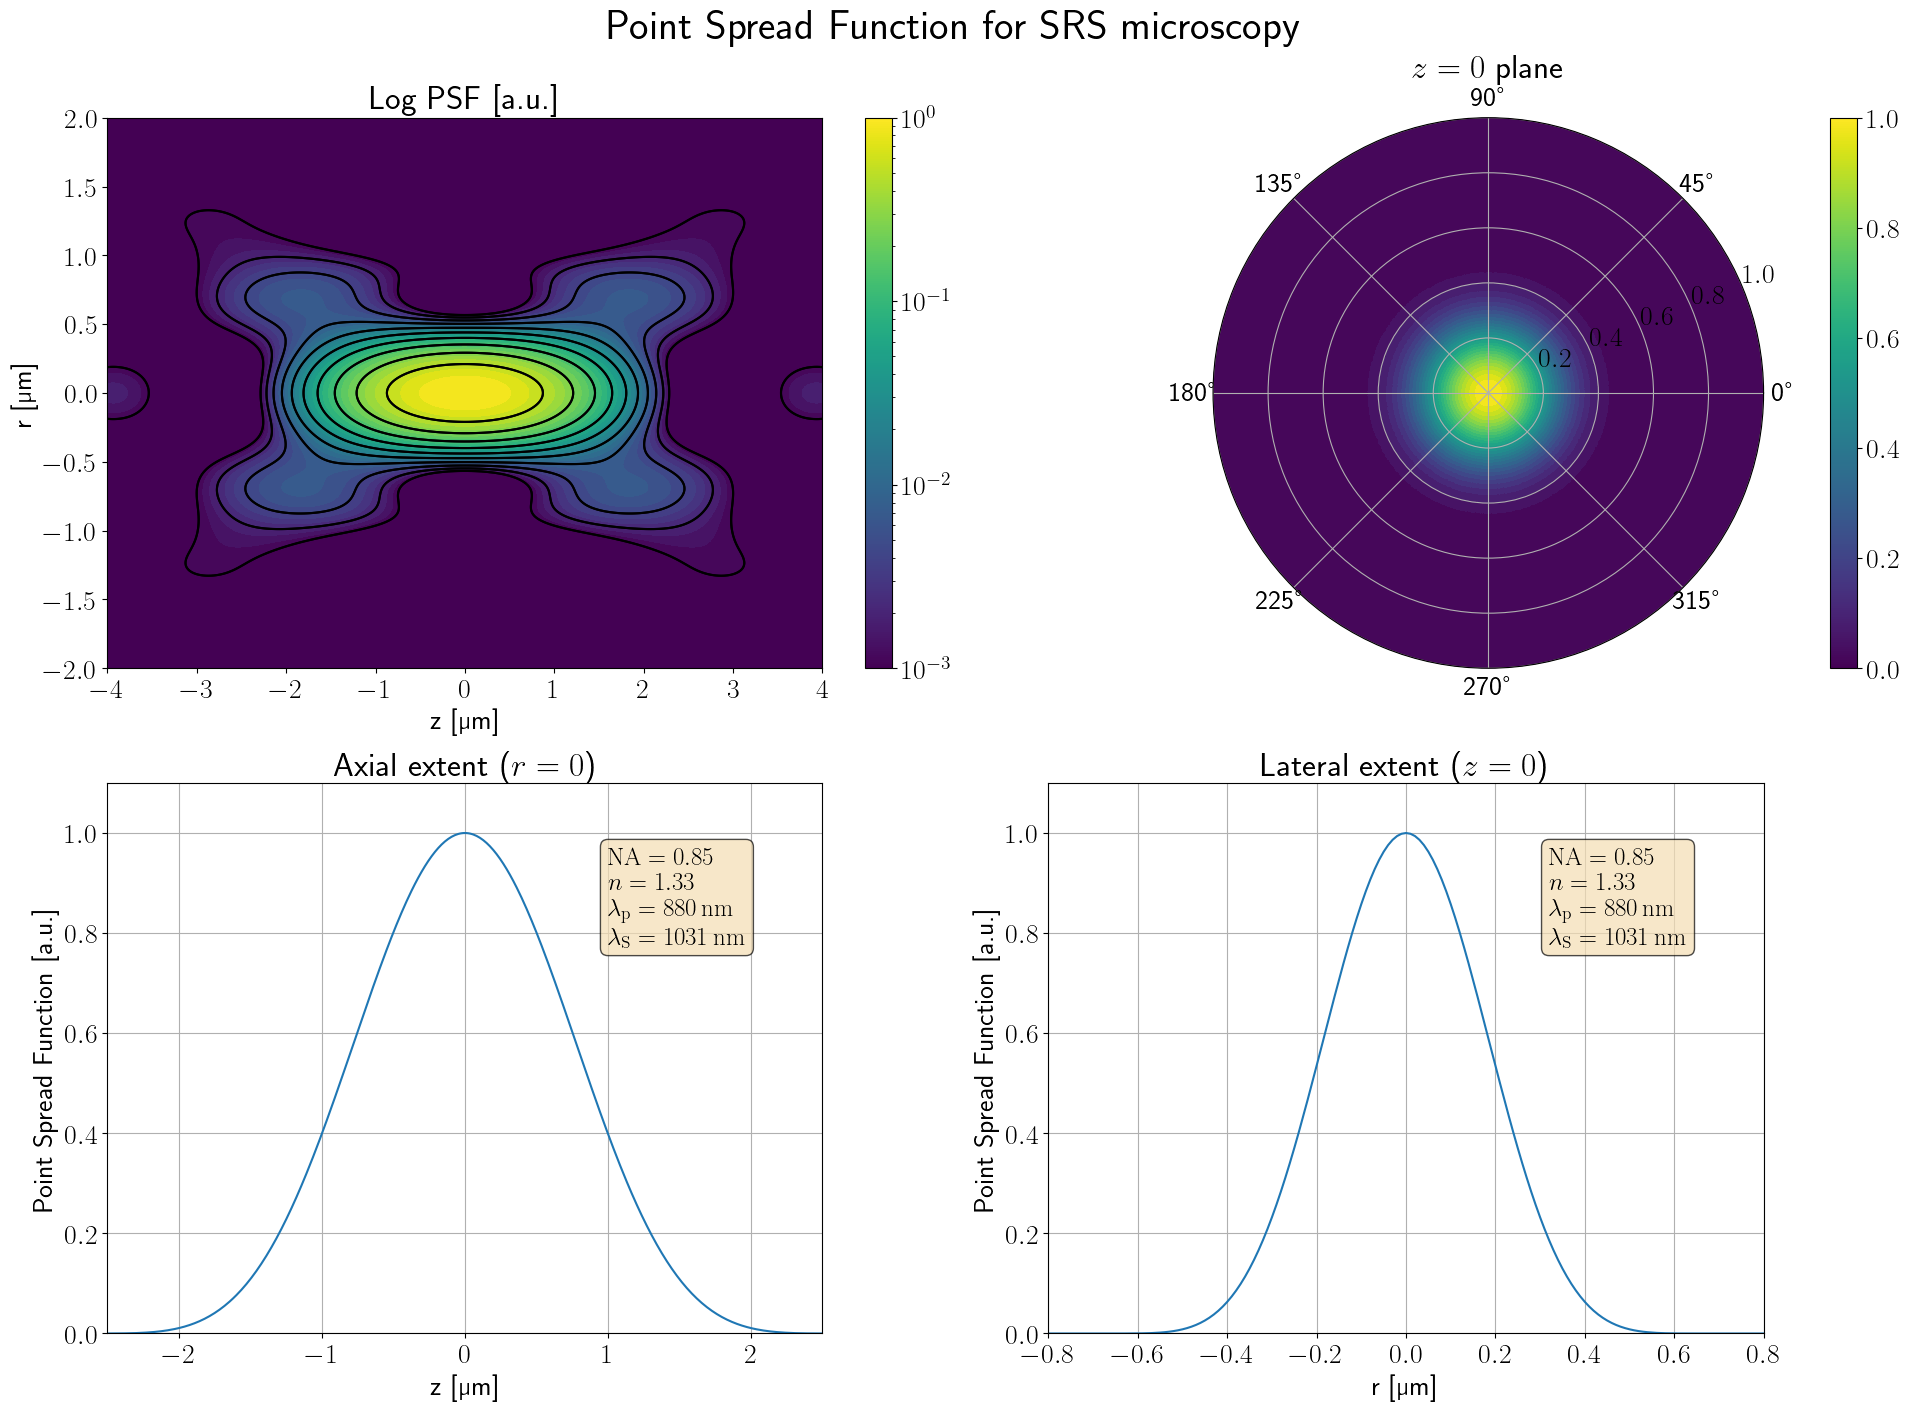

In [24]:
plot_psf(PSF_srs, 'Point Spread Function for SRS microscopy' ,z_array, r_array, theta_array)

C:\Users\dan20\AppData\Local\Temp\ipykernel_10928\2069810545.py:65: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


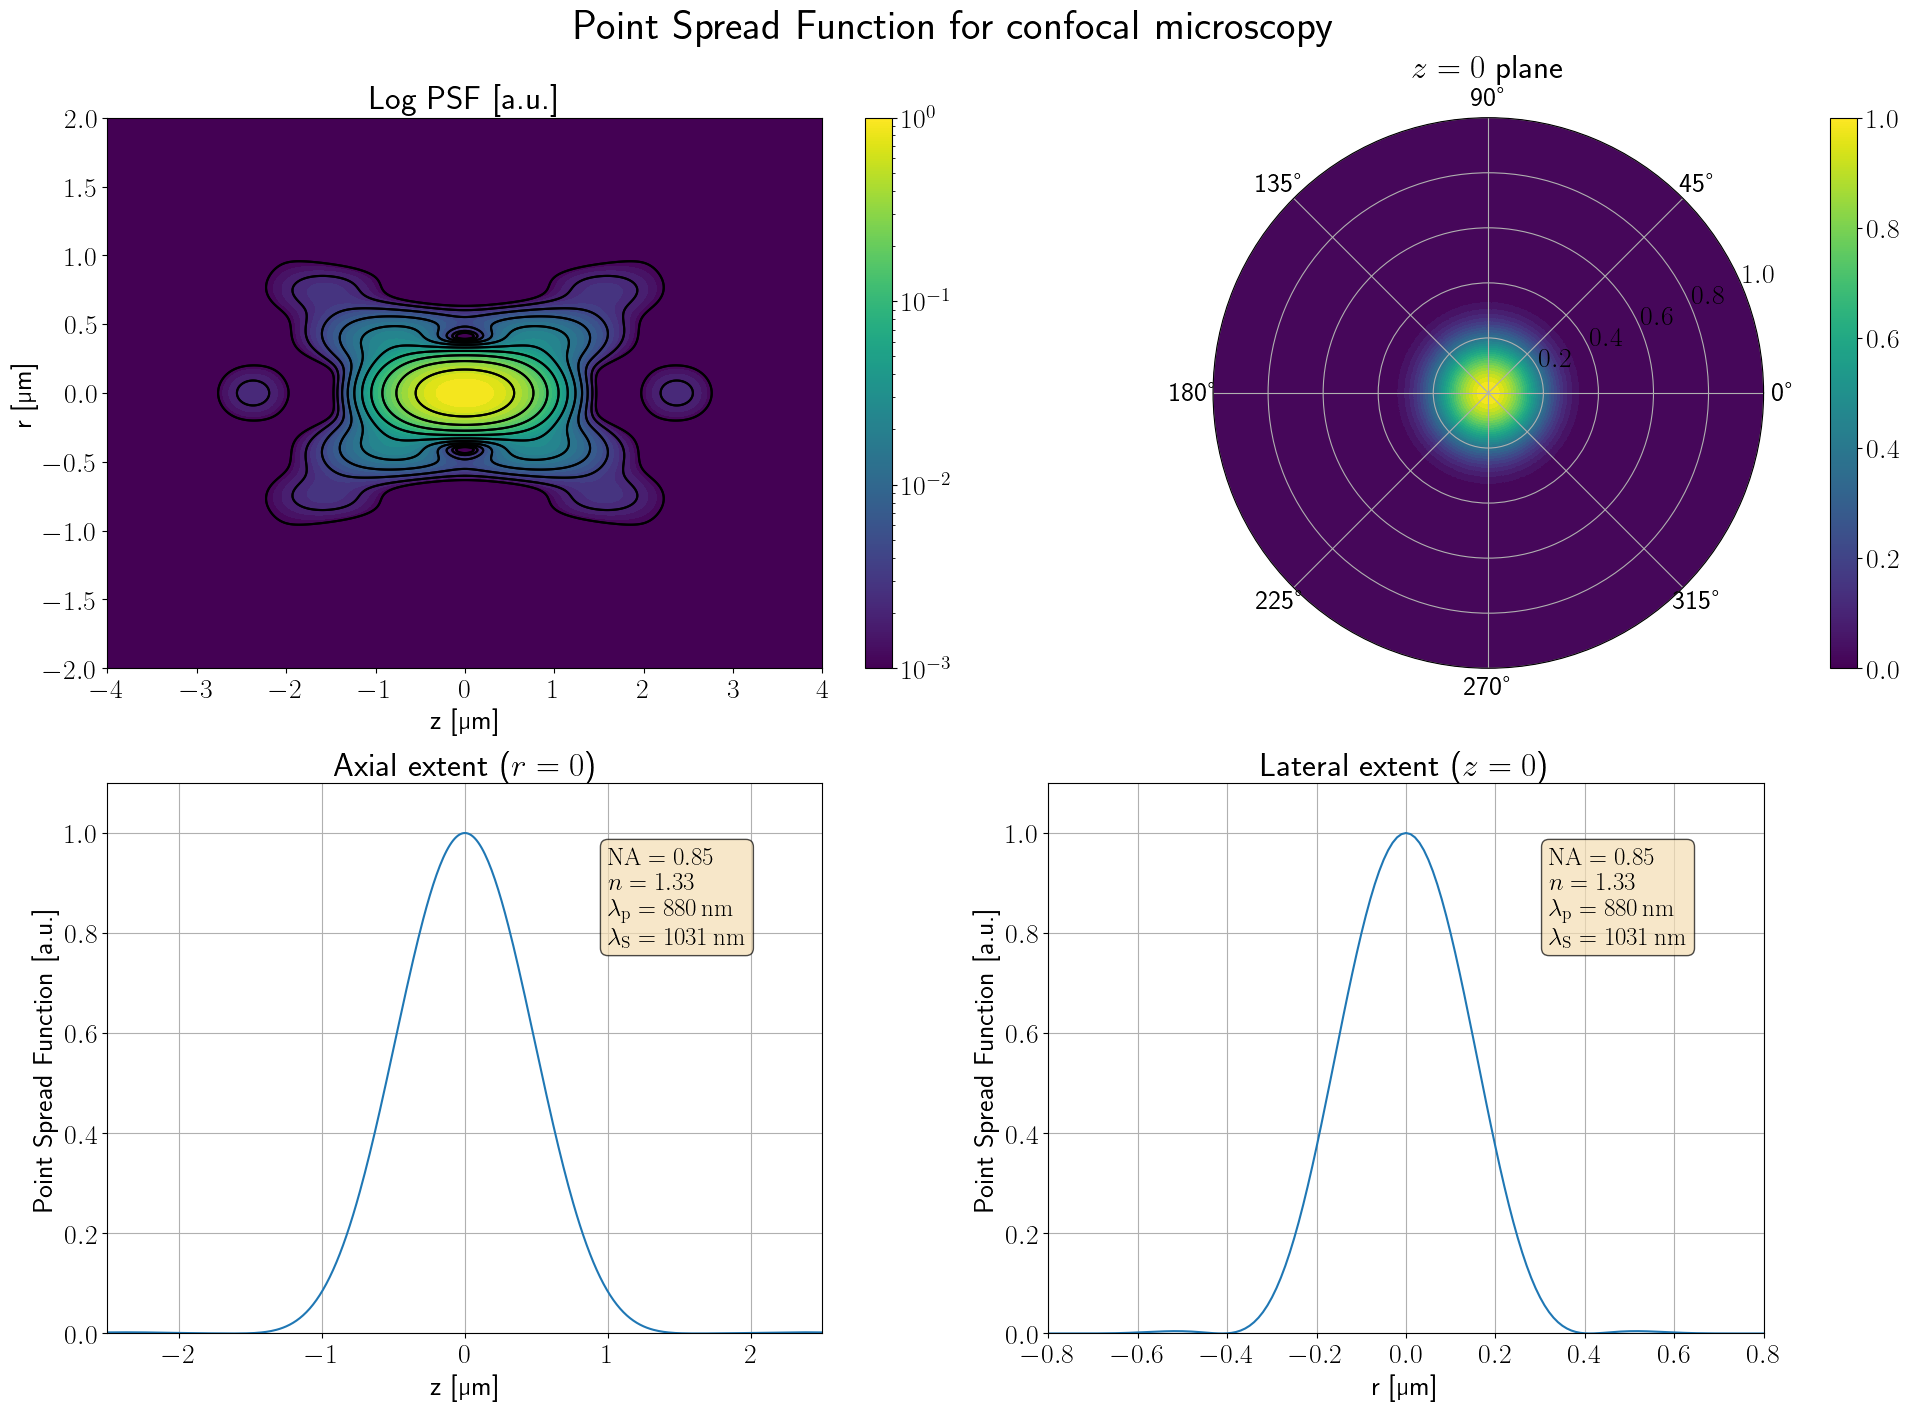

In [25]:
plot_psf(PSF_confocal, 'Point Spread Function for confocal microscopy' ,z_array, r_array, theta_array)

C:\Users\dan20\AppData\Local\Temp\ipykernel_10928\3802864878.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


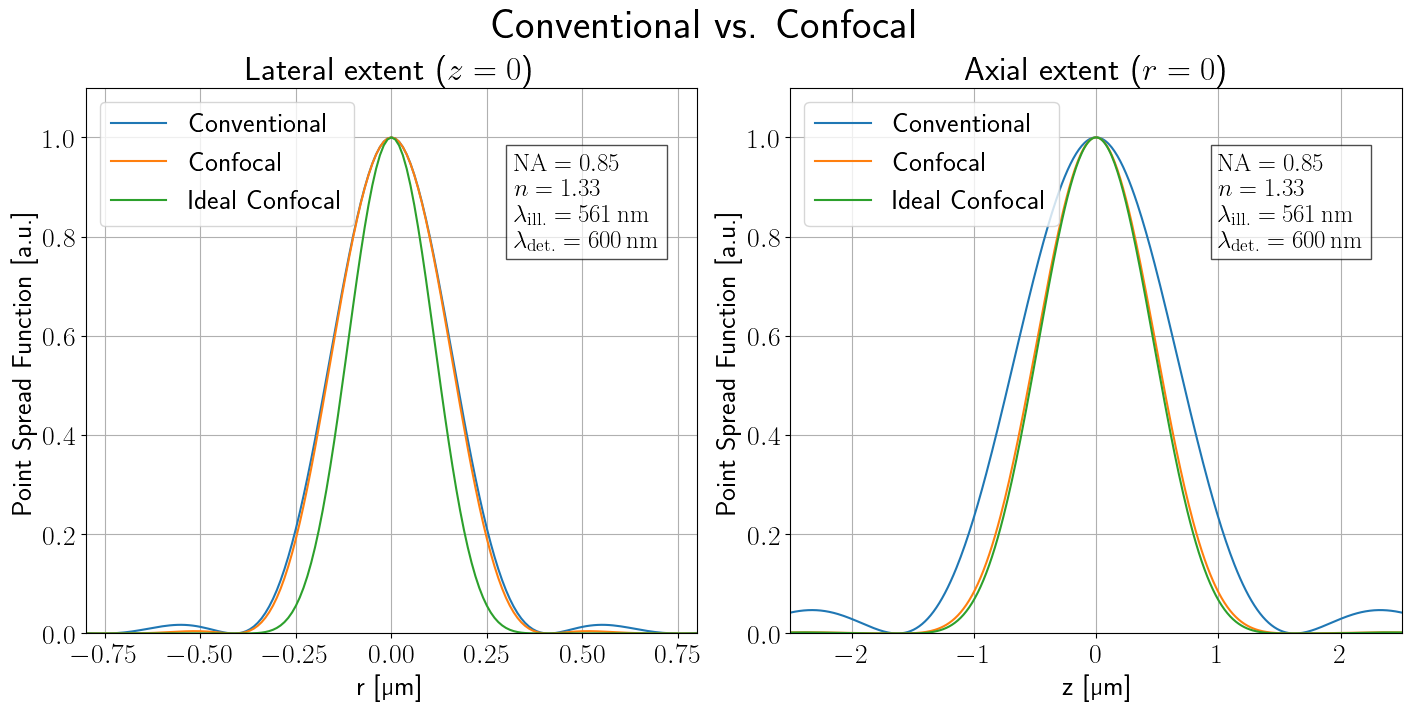

In [28]:
fig, axs =plt.subplot_mosaic([['0','1']],layout='constrained',figsize=(14,7))
fig.suptitle('Conventional vs. Confocal', fontsize=30)
boxprops=dict(boxstyle='square', facecolor='white', alpha=0.7)
ax=axs['0']
boxcontent = '\n'.join((
    r'$\mathrm{NA}=%.2f$' % (num_ap, ),
    r'$n=%.2f$' % (ref_index, ),
    r'$\lambda_{\mathrm{ill.}}=%.0f\,\mathrm{nm}$' % (wl_ill*10**3, ),
    r'$\lambda_{\mathrm{det.}}=%.0f\,\mathrm{nm}$' % (wl_det*10**3, )))

ax.text(0.7, 0.7, boxcontent, transform=ax.transAxes, fontsize=18,
        verticalalignment='bottom', bbox=boxprops)

ax.plot(r_array, PSF_conventional[:,int(z_num/2)],color='tab:blue',label='Conventional')
ax.plot(r_array, PSF_confocal[:,int(z_num/2)],color='tab:orange',label='Confocal')
ax.plot(r_array, PSF_confocal_ideal[:,int(z_num/2)],color='tab:green',label='Ideal Confocal')
ax.set_xlabel(r'r [\textmu m]')
ax.set_ylabel(r'Point Spread Function [a.u.]')
ax.set_title(r'Lateral extent ($z=0$)')
ax.set_xlim(-0.8,0.8)
ax.set_ylim(0.0,1.1)
ax.grid(visible=True)
ax.legend(loc='upper left')


ax=axs['1']
boxcontent = '\n'.join((
    r'$\mathrm{NA}=%.2f$' % (num_ap, ),
    r'$n=%.2f$' % (ref_index, ),
    r'$\lambda_{\mathrm{ill.}}=%.0f\,\mathrm{nm}$' % (wl_ill*10**3, ),
    r'$\lambda_{\mathrm{det.}}=%.0f\,\mathrm{nm}$' % (wl_det*10**3, )))

ax.text(0.7, 0.7, boxcontent, transform=ax.transAxes, fontsize=18,
        verticalalignment='bottom', bbox=boxprops)

ax.plot(z_array, PSF_conventional[int(r_num/2),:],color='tab:blue',label='Conventional')
ax.plot(z_array, PSF_confocal[int(r_num/2),:],color='tab:orange',label='Confocal')
ax.plot(z_array, PSF_confocal_ideal[int(r_num/2),:],color='tab:green',label='Ideal Confocal')
ax.set_xlabel(r'z [\textmu m]')
ax.set_ylabel(r'Point Spread Function [a.u.]')
ax.set_title(r'Axial extent ($r=0$)')
ax.legend(loc='upper left')
ax.set_xlim(-2.5,2.5)
ax.set_ylim(0.0,1.1)
ax.grid(visible=True)
fig.show()